<h3>對影像矩陣做 Convolution 的基本認識與示範

首先對一個影像模糊化（Blurring）

Load an image

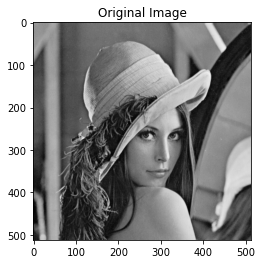

In [1]:
import matplotlib.pyplot as plt
from skimage import io
 
imgfile = "Lenna.png" # 512x512x3
original_img = io.imread(imgfile, as_gray = True)
plt.imshow(original_img, cmap = 'gray')
plt.title("Original Image")
plt.show()

Create a kernel filter (matrix) that will serves as an operator to blur the original image

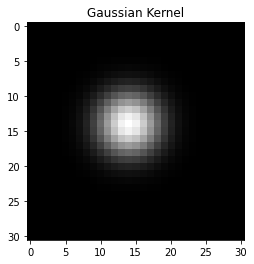

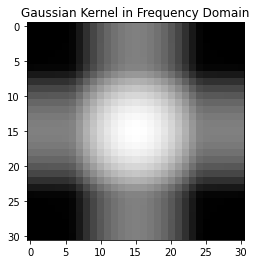

In [2]:
import numpy as np
 
ksize = 31
s = 3
m = ksize // 2
X, Y = np.meshgrid(np.arange(1, ksize+1), np.arange(1, ksize+1))
kernel = (1 / (2 * np.pi * s ** 2)) * np.exp(-((X - m) ** 2 + (Y - m) ** 2) / (2 * s ** 2))
kernel = kernel / np.sum(kernel)
plt.imshow(kernel, cmap = 'gray')
plt.title("Gaussian Kernel") #中間最高兩邊遞減,越高越白
plt.show()
 
fftkernel = np.fft.fft2(kernel)
fftkernel = np.fft.fftshift(fftkernel)
plt.imshow(np.log(np.abs(fftkernel)), cmap = 'gray')
plt.title("Gaussian Kernel in Frequency Domain") #做頻率轉換,顏色變化越多的地方,頻率越高
plt.show()

將原影像與 Kernel filter 做二維的 convolution

若要將影響變為模糊前的大小,要做Zero padding(周圍補0)的動作

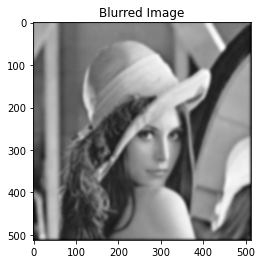

In [3]:
from scipy import signal
 
blur_by_conv = signal.convolve2d(original_img, kernel, mode='same', boundary='fill', fillvalue=0)
plt.imshow(blur_by_conv, cmap = 'gray')
plt.title("Blurred Image")
plt.show()

同上的二維 convolution，但直接使用 scipy.ndimage.gaussian_filter 將影像模糊

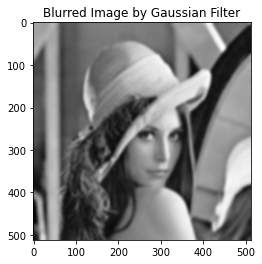

In [4]:
from scipy.ndimage import gaussian_filter
 
blur_by_gaussian = gaussian_filter(original_img, sigma = 3)
plt.imshow(blur_by_gaussian, cmap = 'gray')
plt.title("Blurred Image by Gaussian Filter")
plt.show()

接著對模糊化的影像（blurred image） 進行 Sharpen

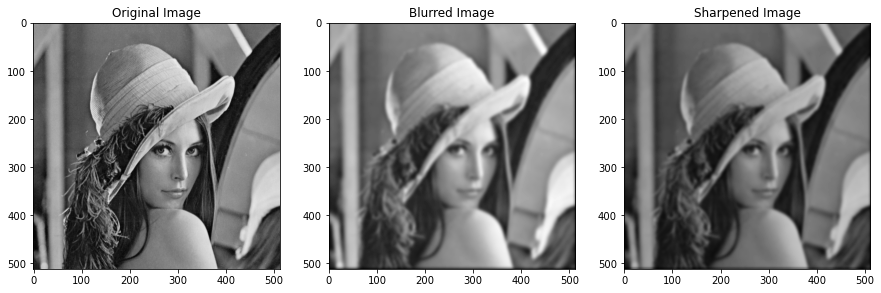

In [5]:
sharpen_kernel = np.array([[0, -1,  0],
                           [-1,  5, -1],
                           [0, -1,  0]]) # Laplacian kernel
# sharpen_kernel = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, 0]]) / 3
# sharpen_kernel = np.array([[1, -2, 1],
#                            [-2, 5, -2],
#                            [1, -2, 1]])
# sharpen_kernel = np.array([[-0.0023, -0.0432, -0.0023],
#                            [-0.0432, 1.182, -0.0432],
#                            [-0.0023, -0.0432, -0.0023]])
sharpen_by_conv = signal.convolve2d(blur_by_conv, sharpen_kernel, mode='same', boundary='fill', fillvalue=0)
 
fig, ax = plt.subplots(1, 3, figsize = (15, 5))
ax[0].imshow(original_img, cmap = 'gray')
ax[0].set_title("Original Image")
ax[1].imshow(blur_by_conv, cmap = 'gray')
ax[1].set_title("Blurred Image")
ax[2].imshow(sharpen_by_conv, cmap = 'gray')
ax[2].set_title("Sharpened Image")
plt.show()

範例 2：Detect the edges of an image

Detect vertical edges

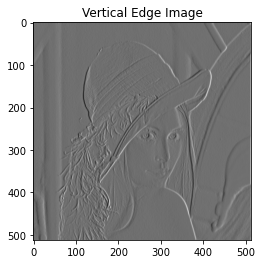

In [7]:
edge_v_kernel = np.array([[-1, 0, 1],
                        [-1, 0, 1],
                        [-1, 0, 1]]) # Prewitt
# edge_v_kernel = np.array([[-1.,0.,1.],[-2.,0.,2.],[-1.,0.,1.]])/8 # Sobel
edge_v_by_conv = signal.convolve2d(original_img, edge_v_kernel, mode='same', boundary='fill', fillvalue=0)
plt.imshow(edge_v_by_conv, cmap = 'gray')
plt.title("Vertical Edge Image")
plt.show()

Detect horizontal edges

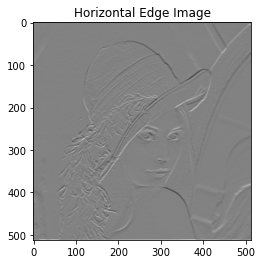

In [8]:
edge_h_kernel = np.array([[-1, -1, -1],
                          [0, 0, 0],
                          [1, 1, 1]])
# edge_h_kernel = np.array([[-1.,-2.,-1.],[0.,0.,0.],[1.,2.,1.]])/8 # Sobel
edge_h_by_conv = signal.convolve2d(original_img, edge_h_kernel, mode='same', boundary='fill', fillvalue=0)
plt.imshow(edge_h_by_conv, cmap = 'gray')
plt.title("Horizontal Edge Image")
plt.show()

Detect vertical edges + Detect horizontal edges

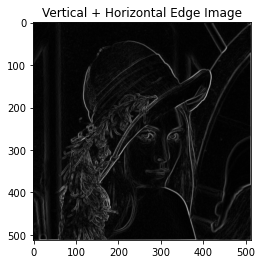

In [9]:
edge_v_h_by_conv = np.sqrt(edge_v_by_conv ** 2 + edge_h_by_conv ** 2)
plt.imshow(edge_v_h_by_conv, cmap = 'gray')
plt.title("Vertical + Horizontal Edge Image")
plt.show()

Show the results

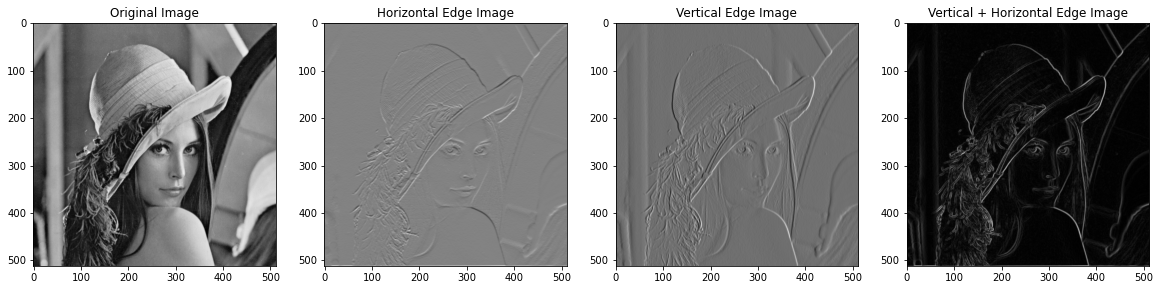

In [10]:
fig, ax = plt.subplots(1, 4, figsize = (20, 5))
ax[0].imshow(original_img, cmap = 'gray')
ax[0].set_title("Original Image")
ax[1].imshow(edge_h_by_conv, cmap = 'gray')
ax[1].set_title("Horizontal Edge Image")
ax[2].imshow(edge_v_by_conv, cmap = 'gray')
ax[2].set_title("Vertical Edge Image")
ax[3].imshow(edge_v_h_by_conv, cmap = 'gray')
ax[3].set_title("Vertical + Horizontal Edge Image")
plt.show()

使用 PyTorch 做水平線偵測

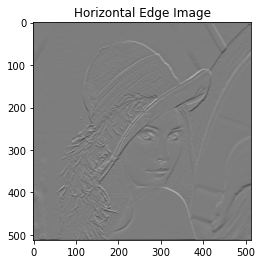

In [11]:
import torch
import torch.nn.functional as F
import torch.nn as nn
 
X_torch = torch.from_numpy(original_img).float()
# edge_h_kernel_torch = torch.tensor([[-1, -1, -1],
#                               [0, 0, 0],
#                               [1, 1, 1]])
X_torch = X_torch.reshape(1, 1, 512, 512) # (batch_size, channel, height, width)
h_torch = torch.from_numpy(edge_h_kernel).float()
h_torch = h_torch.reshape(1, 1, 3, 3) # (out_channel, in_channel, kernel_height, kernel_width)
 
edge_h_by_conv_torch = F.conv2d(X_torch, h_torch, padding = 1)
edge_h_by_conv_numpy = edge_h_by_conv_torch.numpy().squeeze() # (batch_size, channel, height, width) -> (height, width)
 
plt.imshow(edge_h_by_conv_numpy, cmap = 'gray')
plt.title("Horizontal Edge Image")
plt.show()

範例 3：使用特別圖像來凸顯水平與垂直線的偵測

製作一個簡單的十字圖

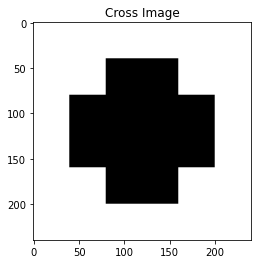

In [12]:
imsz = 240
cross = np.ones((imsz,imsz))
cross[int(imsz/3):int(2*imsz/3),int(imsz/6):int(5*imsz/6)]=0
cross[int(imsz/6):int(5*imsz/6),int(imsz/3):int(2*imsz/3)]=0
fig = plt.figure()
plt.imshow(cross, cmap = 'gray')
plt.title("Cross Image")
plt.show()

偵測水平線

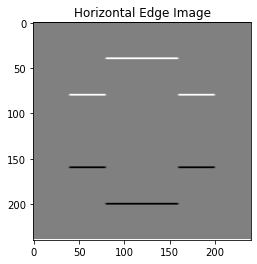

In [13]:
cross_edge_h_by_conv = signal.convolve2d(cross, edge_h_kernel, mode='same', boundary='fill', fillvalue=0)
plt.imshow(cross_edge_h_by_conv, cmap = 'gray')
plt.title("Horizontal Edge Image")
plt.show()

偵測垂直線

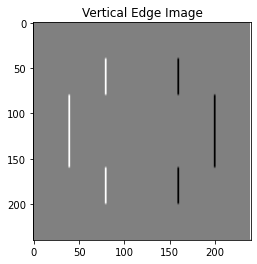

In [14]:
cross_edge_v_by_conv = signal.convolve2d(cross, edge_v_kernel, mode='same', boundary='fill', fillvalue=0)
plt.imshow(cross_edge_v_by_conv, cmap = 'gray')
plt.title("Vertical Edge Image")
plt.show()

偵測水平線 + 垂直線

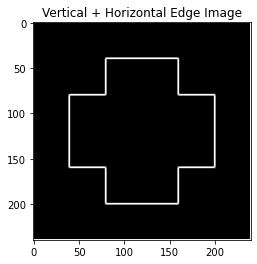

In [15]:
corss_v_h_by_conv = np.sqrt(cross_edge_v_by_conv ** 2 + cross_edge_h_by_conv ** 2)
plt.imshow(corss_v_h_by_conv, cmap = 'gray')
plt.title("Vertical + Horizontal Edge Image")
plt.show()